<a href="https://colab.research.google.com/github/NikosAng/UEA-macro-lectures/blob/main/MAIN_LECTURE1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install pandas_datareader ruptures pmdarima
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as web
from statsmodels.tsa.stattools import adfuller, kpss, zivot_andrews, coint
from statsmodels.tsa.arima.model import ARIMA
plt.rcParams["figure.dpi"] = 110


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.8 MB/s eta 0:00:00


Let's grab US real GDP data from FRED. We'll use the GDPC1 series (Real Gross Domestic Product) starting from 1950-01-01.

We'll then do a quick sanity check by displaying the first few rows and counting non-missing values to verify we have a complete quarterly time series before proceeding with our analysis.

In [ ]:
#@title 2. Pull & Inspect Data
# Fetch quarterly real GDP from FRED
gdp = web.DataReader("GDPC1", "fred", "1950-01-01")
gdp = gdp.resample("Q").last()

print("GDP head:")
display(gdp.head())
print("Non-missing count:", gdp.count().GDPC1)


GDP head:


<ipython-input-5-3fa7c6034f5c>:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  gdp = gdp.resample("Q").last()


,GDPC1
DATE,
1950-03-31,2346.104
1950-06-30,2417.682
1950-09-30,2511.127
1950-12-31,2559.214
1951-03-31,2593.967


Non-missing count: 300


Before diving into real data, let's simulate two canonical time series processes to build intuition about persistence patterns.

For the trend-stationary (TS) process, we generate:

$y_t = 0.05t + u_t$, where $u_t = 0.8u_{t-1} + \varepsilon_t$ and $\varepsilon_t \sim N(0,0.5^2)$

The TS process combines a deterministic linear trend with stationary AR(1) noise. Though the series fluctuates, these deviations are temporary—the process always reverts to its underlying trend path.

For the difference-stationary (DS) process, we generate:

$y_t = y_{t-1} + 0.02 + \varepsilon_t$, where $\varepsilon_t \sim N(0,0.5^2)$

This random walk with drift accumulates shocks permanently. Each innovation shifts the level of the series forever, creating a path that wanders without any fixed center of gravity.

The contrast between these processes shows a fundamental question in macroeconomics: when shocks hit the economy, do their effects fade (TS) or persist indefinitely (DS)?

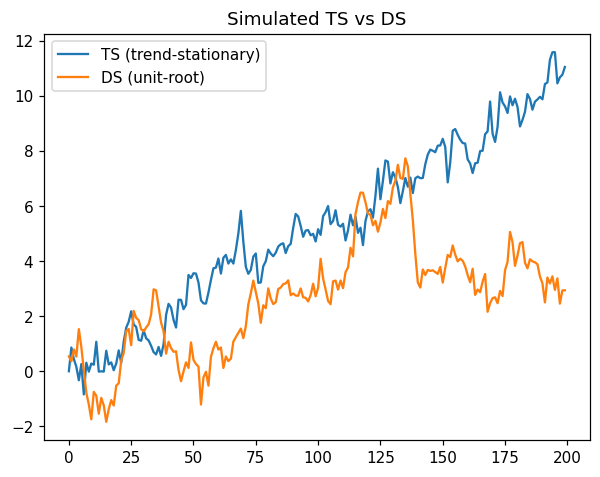

In [ ]:
#@title 3. Simulate TS vs DS (intuition)
np.random.seed(1)
T=200
# TS: linear trend + AR(1) noise
phi=0.8; u=np.zeros(T)
for t in range(1,T): u[t]=phi*u[t-1]+np.random.randn()*0.5
ts = 0.05*np.arange(T)+u
# DS: random walk with drift
rw = np.cumsum(0.02+np.random.randn(T)*0.5)

plt.plot(ts, label="TS (trend-stationary)")
plt.plot(rw, label="DS (unit-root)")
plt.legend(); plt.title("Simulated TS vs DS"); plt.show()


Now we'll implement formal tests to determine whether our GDP series exhibits a unit root. We create a helper function that applies both the Augmented Dickey-Fuller (ADF) and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) tests in sequence.

These tests approach the stationarity question from complementary angles:
- The ADF test uses $H_0$: series has a unit root (is I(1)), against $H_1$: series is stationary (I(0))
- The KPSS test uses $H_0$: series is stationary (I(0)), against $H_1$: series has a unit root (is I(1))

This complementary approach provides more robust inference than either test alone. We apply both tests to:
1. The log-level of real GDP
2. The first difference of log GDP (approximately, the growth rate)

For proper interpretation:
- If ADF rejects ($p < 0.05$) and KPSS fails to reject ($p > 0.05$): Strong evidence for stationarity
- If ADF fails to reject ($p > 0.05$) and KPSS rejects ($p < 0.05$): Strong evidence for a unit root
- Mixed results suggest potential specification issues or structural breaks

The results confirm that log GDP shows strong evidence of a unit root (ADF p=0.051, KPSS p=0.010), while GDP growth is clearly stationary (ADF p=0.000, though with a slightly ambiguous KPSS result). This aligns with macroeconomic theory that output levels contain permanent components, while growth rates are stationary.

In [ ]:
#@title 4. ADF & KPSS Helper + Tests
def unitroot_tests(y, name):
    y = y.dropna()
    print(f"→ {name}:  n={len(y)} obs")
    adf_p = adfuller(y, autolag="AIC")[1]
    kpss_p= kpss(y, nlags="auto", regression="c")[1]
    print(f"    ADF  p-value = {adf_p:.3f}")
    print(f"    KPSS p-value = {kpss_p:.3f}\n")

# Prepare series
log_gdp  = np.log(gdp["GDPC1"]).dropna()
dlog_gdp = log_gdp.diff().dropna()

# Run tests
unitroot_tests(log_gdp,  "log GDP level")
unitroot_tests(dlog_gdp, "Δ log GDP growth")


→ log GDP level:  n=300 obs
    ADF  p-value = 0.051
    KPSS p-value = 0.010

→ Δ log GDP growth:  n=299 obs
    ADF  p-value = 0.000
    KPSS p-value = 0.030



<ipython-input-7-31cc967ae338>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p= kpss(y, nlags="auto", regression="c")[1]


Standard unit root tests can be misleading when a series experiences a structural break. If the data generating process shifts abruptly, it can falsely appear non-stationary even when each regime is actually stationary around different means or trends.

The Zivot-Andrews test addresses this problem by endogenously identifying the most likely break point. Unlike earlier tests that required pre-specifying the break date, this approach searches across all possible dates to find when the data most strongly suggests a structural change.

Specifically, for each potential break date, the test estimates:

$$\Delta y_t = \alpha + \beta t + \gamma DU_t + \rho y_{t-1} + \sum_{j=1}^{k} \delta_j \Delta y_{t-j} + \varepsilon_t$$

Where $DU_t$ is a dummy that equals 1 after the break date. The test identifies the date where $\rho$ (the unit root parameter) is most negative - that is, where the evidence against a unit root is strongest when allowing for a break.

The null hypothesis remains that the series has a unit root with no structural break. Rejecting this null suggests either stationarity or a break (or both). We apply this test to log GDP to determine whether the apparent unit root might actually be a structural change in the economic growth process.

In [ ]:
# 5. Structural Break Test (Zivot–Andrews)
from statsmodels.tsa.stattools import zivot_andrews

y = log_gdp.copy()

# unpack all 5 returns: stat, p‐value, crit‐dict, used‐lag, break‐location
za_stat, za_p, za_crit, za_lag, za_bp = zivot_andrews(y, maxlag=8, regression="c")

print(f"Zivot–Andrews statistic = {za_stat:.3f}")
print(f"p-value                  = {za_p:.3f}")
print(f"critical values          = {za_crit}")
print(f"chosen lag               = {za_lag}")
print(f"break at index           = {za_bp}  → quarter = {y.index[za_bp].date()}")


Zivot–Andrews statistic = -3.895
p-value                  = 0.417
critical values          = {'1%': np.float64(-5.27644), '5%': np.float64(-4.81067), '10%': np.float64(-4.56618)}
chosen lag               = 1
break at index           = 231  → quarter = 2007-12-31


Having established that the GDP growth rate is stationary, we can fit a simple AR(1) model to quantify its persistence. The AR(1) specification models the current growth rate as a function of its previous value plus a white noise shock:
$$y_t = \phi y_{t-1} + \varepsilon_t$$
Where $y_t$ represents the first difference of log GDP. The autoregressive coefficient $\phi$ directly measures persistence - how strongly today's growth depends on last period's growth.

From this estimated model, we calculate the half-life, which measures how long it takes for a shock's effect to diminish by 50%:
$$HL = \frac{\ln(0.5)}{\ln|\phi|}$$
The half-life provides an intuitive metric of persistence in quarters, making it easier to interpret than the raw coefficient.

We then visualize the impulse response function (IRF), which traces how a one-unit shock propagates through time. For an AR(1) process, the IRF at horizon $h$ is simply $\psi_h = \phi^h$. This plot reveals the complete decay pattern of shocks, showing both their initial impact and how quickly they dissipate back to zero.

The results are striking - with φ = 0.123, GDP growth shocks have a remarkably short half-life of just 0.3 quarters. As the stem plot shows, effects essentially vanish after the first quarter. While GDP levels may contain permanent components (as our unit root tests suggested), quarter-to-quarter growth innovations are highly transitory.

This finding reveals a key macroeconomic insight: while level shocks persist indefinitely, growth rate shocks dissipate almost immediately. After an unusually strong or weak quarter, the economy quickly returns to its average growth rate. For policymakers, this suggests that efforts to boost short-term growth will have only fleeting effects on growth rates, even if they permanently alter the level of output.

Estimated φ = 0.123
Half-Life ≈ 0.3 quarters


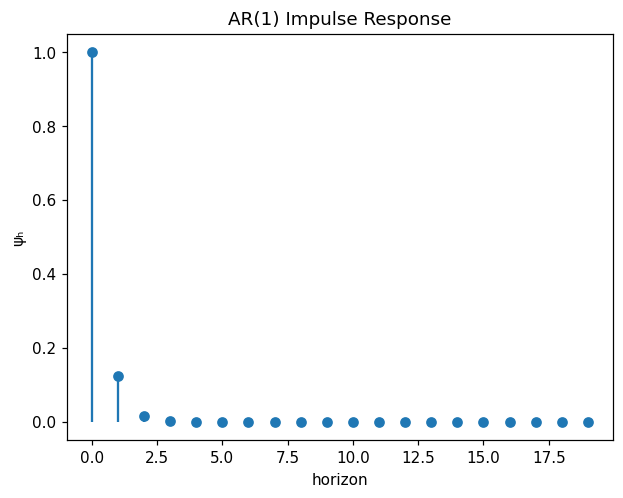

In [ ]:
#@title 6. AR(1) Fit → Half-Life & IRF (fixed stem call)
y = dlog_gdp.copy()
model = ARIMA(y, order=(1,0,0)).fit()
phi = model.params["ar.L1"]
hl  = np.log(0.5)/np.log(abs(phi))
print(f"Estimated φ = {phi:.3f}")
print(f"Half-Life ≈ {hl:.1f} quarters")

# IRF
H = 20
psi = phi**np.arange(H)
plt.stem(np.arange(H), psi, basefmt=" ")
plt.title("AR(1) Impulse Response")
plt.xlabel("horizon")
plt.ylabel("ψₕ")
plt.show()


Here we use the Variance-Ratio (VR) test to gauge persistence without imposing an ARMA structure. This approach, pioneered by Cochrane (1988), offers a non-parametric perspective on whether GDP follows a random walk.

For each horizon $k$, we calculate:

$$\mathrm{VR}(k) = \frac{\mathrm{Var}(y_t - y_{t-k})}{k \cdot \mathrm{Var}(\Delta y_t)}$$

The intuition behind this ratio is straightforward:
- If GDP follows a pure random walk ($I(1)$), then $\mathrm{VR}(k) \approx 1$ for all horizons
- If GDP is stationary ($I(0)$), then $\mathrm{VR}(k) \to 0$ as $k$ increases
- Intermediate values suggest a mixture of permanent and transitory components

The plot shows the empirical VR curve against the horizontal benchmark line at 1 (representing a pure random walk). The extent to which the VR profile falls below 1 at longer horizons indicates the degree of mean reversion in the series.

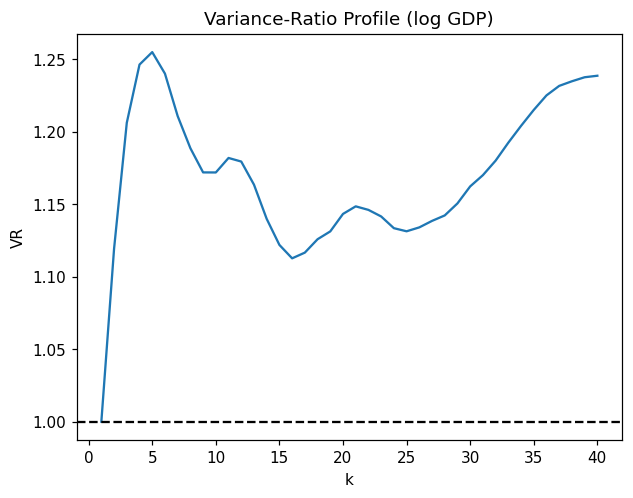

In [ ]:
#@title 7. Variance-Ratio Profile
def vr_profile(y, max_h=40):
    y = y.dropna().to_numpy()
    d = np.diff(y)
    v1 = np.var(d, ddof=0)
    vr = [np.var(y[h:]-y[:-h], ddof=0)/(h*v1) for h in range(1,max_h+1)]
    return np.array(vr)

vr = vr_profile(log_gdp)
h = np.arange(1,len(vr)+1)
plt.plot(h, vr, label="VR(k)")
plt.axhline(1, ls="--", color="k")
plt.title("Variance-Ratio Profile (log GDP)")
plt.xlabel("k")
plt.ylabel("VR")
plt.show()